# Integrated Gradients
This notebook uses the Integrated Gradients method to glean more information about what parts of the voltage and current data are most important to the performance of the CNN model.

# Imports

In [1]:
import os
dir_path = os.getcwd()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf

import scripts.process_B6_data as pcs
import scripts.ML_plotting as mlplt

## Input Data
To use the pre-processed data go to the `Simple Data Download` section.

In [ ]:
# If true, certain variables that are unlikely to be used will be deleted
# to save up memory.
save_memory = True

# get file location and row #'s of data in the file
cc_crg_data_info = pcs.get_data_location(batch_list, 6, "Cc_crg", "C")
cv_crg_data_info = pcs.get_data_location(batch_list, 7, "Cv_crg", "C")

# Open data files and retrive relevant characterization CC charge data.
# Order data dataframes into dictionary that is cycle index by cell number.
cc_data_dict = pcs.get_cc_charge_data(cc_crg_data_info)
cv_data_dict = pcs.get_cc_charge_data(cv_crg_data_info)

# combine data_dict's into one
data_dict = pcs.concat_data_dict([cc_data_dict, cv_data_dict])

# rename temperature col's
data_dict = pcs.rename_temp_col(data_dict)

# check that data looks alright
# pcs.plot_data_dict(data_dict, "Voltage(V)")

# remove unwanted cycles from data
rmv_lst = [(1, 25),(2, 25),(3, 25),(4, 25),(5, 25),(6, 25),(7, 25),(8, 25),(9, 25),(10, 25),(11, 25),(12, 25),(14, 162),(15, 161)]
data_dict_copy = pcs.remove_cycles(data_dict, rmv_lst)

# Remove chosen cells from data dictionary
rmv_cells = [4,14,15]
data_dict_copy = pcs.remove_cells(data_dict_copy, rmv_cells)

# check that data looks alright
# pcs.plot_data_dict(data_dict_copy, "Voltage(V)")

# reduce the lengths of data in data_dict to the shortest one in the set.
data_dict_copy = pcs.extend_data_dict(data_dict_copy)

# split data into training and validation data sets
train_data, val_data = pcs.split_data(data_dict_copy, split=0.2, seed=3)

# Get list of dataframes as a multi-dimensional array that follows our tensorflow CNN input format.
cols = ['Voltage(V)','Current(A)','Temp(C)_1']
train_data_array = pcs.get_data_array(train_data, cols)
val_data_array = pcs.get_data_array(val_data, cols)

# reduce the resolution of the data to improve training times
train_features = np.array([arr[0:-1:7,:] for arr in train_data_array], dtype=object)
val_features = np.array([arr[0:-1:7,:] for arr in val_data_array], dtype=object)
print(np.shape(train_features))
print(np.shape(val_features))

if save_memory:
    del batch10, shape10, batch11, shape11
    del cc_crg_data_info, cv_crg_data_info, cc_data_dict, cv_data_dict

In [ ]:
train_features_notemp = train_features[:,:,0:2]
val_features = val_features[:,:,0:2]
print(train_features_notemp.shape)
print(val_features.shape)

## Output Data
To use the pre-processed data go to the `Simple Data Download` section.

In [ ]:
SOH_dict = pcs.get_SOH(batch_list)

SOH_dict_copy = pcs.remove_cycles(SOH_dict, rmv_lst, output=True)

SOH_dict_copy = pcs.remove_cells(SOH_dict_copy, rmv_cells)

train_output_data, val_output_data = pcs.split_data(SOH_dict_copy, split=0.2)

# Make dictionary into array and then flatten it so it is a column vector for one value per cycle.
train_output_array = np.array([  [ elem[1] for elem in value ] for key, value in train_output_data.items() ], dtype=object)
val_output_array = np.array([ [ elem[1] for elem in value ] for key, value in val_output_data.items() ], dtype=object)

train_labels = train_output_array.reshape(train_data_array.shape[0],1)
val_labels = val_output_array.reshape(val_data_array.shape[0],1)
print(train_labels.shape)
print(val_labels.shape)

## Randomize Features and Labels

This is to validate that the input data is not dependent on input order e.g. insure that the model is training on one train cycle at a time. It's not always run.

To use the pre-processed data go to the `Simple Data Download` section.

In [ ]:
# choose seed so randomization is repeatable
np.random.seed(3)

# make each element of the first dimension a tuple
# with the first element as the SOH so we know they
# are matching pairs.
train_shuffled = np.array([ (train_labels[idx,:], elem) for idx, elem in enumerate(train_features) ], dtype=object)
val_shuffled = np.array([ (val_labels[idx,:], elem) for idx, elem in enumerate(val_features) ], dtype=object)

# randomize array ordering
np.random.shuffle(train_shuffled)
np.random.shuffle(val_shuffled)

# unpack the tuple so that features and labels are separate again
train_features_shuffled = np.array([ elem[1] for elem in train_shuffled ])
train_labels_shuffled = np.array([ elem[0] for elem in train_shuffled ])
val_features_shuffled = np.array([ elem[1] for elem in val_shuffled ])
val_labels_shuffled = np.array([ elem[0] for elem in val_shuffled ])

In [ ]:
print(train_features_shuffled.shape)
print(val_features_shuffled.shape)
print(train_labels_shuffled.shape)
print(val_labels_shuffled.shape)

## Input Data
To use the pre-processed data go to the `Simple Data Download` section.

In [ ]:
# use data_dict from earlier because it contains the data we need and we don't want to double load the data into the notebook.
MG_data = {}
MG_data[14] = copy.deepcopy(data_dict[14])
MG_data[15] = copy.deepcopy(data_dict[15])

# Remove unwanted cycles (it's a good idea to plot the data here to decide what cycles to remove, I've left it out for brevity)
cyc_lst = [(14, 162),(15, 161)]#,(14,161),(15,160),(15,159),(15,158),(15,157),(15,156)]
MG_data = pcs.remove_cycles(MG_data, cyc_lst)

# rename temperature col's
MG_data = pcs.rename_temp_col(MG_data)

# reduce the lengths of data in data_dict to the shortest one in the set.
MG_data = pcs.extend_data_dict(MG_data)

# Get list of dataframes as a multi-dimensional array that follows our tensorflow CNN input format.
cols = ['Voltage(V)','Current(A)','Temp(C)_1']
MG_data_array = pcs.get_data_array(MG_data, cols)

# reduce the resolution of the data to improve training times
MG_features = np.array([arr[0:-1:7,:] for arr in MG_data_array], dtype='float32')
print(np.shape(MG_features))

# correct the shape of the data so that it matches the training size
MG_features = pcs.correct_array_shape(MG_features, train_features.shape[1])
print(np.shape(MG_features))

In [ ]:
MG_features = MG_features[:,:,0:2]
print(MG_features.shape)

## Output Data
To use the pre-processed data go to the `Simple Data Download` section.

In [ ]:
MG_soh = {}
MG_soh[14] = copy.deepcopy(SOH_dict[14])
MG_soh[15] = copy.deepcopy(SOH_dict[15])

# Remove relevant cycles
MG_soh_copy = pcs.remove_cycles(MG_soh, cyc_lst, output=True)

# Make dictionary into array and then flatten it so it is a column vector for one value per cycle.
MG_soh_array = np.array([  [ elem[1] for elem in value ] for key, value in MG_soh_copy.items() ], dtype=object)

MG_labels = np.hstack(MG_soh_array).reshape(MG_features.shape[0],1)
MG_labels = MG_labels.astype('float32')
print(MG_labels.shape)

if save_memory:
    del MG_soh_array

In [ ]:
pcs.plot_data_dict(MG_data, "Voltage(V)", step_time=False)

# Simple Data Download

In [3]:
def load_np_Test_Data(data_name):
    """
    Load file from the Data folder with the filename equal to data_name.
    Args:
        data_name(str): filename to be loaded.
    Returns:
        numpy array: loaded data array from Data folder.
    """
    return np.load(os.path.join(dir_path, 'Data', '') + data_name + '.npy', allow_pickle=True)

In [4]:
# Load training, validation, and MG data sets
train_features = load_np_Test_Data('train_features').astype('float64')[:,:,:2]
train_labels = load_np_Test_Data('train_labels').astype('float64')
val_features = load_np_Test_Data('val_features').astype('float64')[:,:,:2]
val_labels = load_np_Test_Data('val_labels').astype('float64')
MG_features = load_np_Test_Data('MG_features').astype('float64')[:,:,:2]
MG_labels = load_np_Test_Data('MG_labels').astype('float64')

# Load Model

In [5]:
model = tf.keras.models.load_model(os.path.join(dir_path, 'CNN Model'))

In [6]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 417, 2)           5         
 ion)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 417, 5)            55        
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 208, 5)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 208, 10)           260       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 104, 10)          0         
 g1D)                                                            
                                                      

# Integrated Gradients

This section is adapted from the tutorials at https://www.tensorflow.org/tutorials/interpretability/integrated_gradients and https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/blogs/integrated_gradients/integrated_gradients.ipynb. The intention of this method is to describe the relation between the models predictions and its input. The idea is typically explained in terms of object detection models that have images as input and classification probabilities as output. Here is the best explanation that I have found (second link), 

"The basic intuition is to measure a feature's importance to your model by incrementally increasing a feature's intensity between its absense (baseline) and its input value, compute the change between your model's predictions with respect to the original feature at each step (gradient), and average these incremental changes together (integral)."

In our case the intuition is slightly different because we have a regression model with blocks of timeseries data predicting a numerical value (SOH). This becomes especially prevalent when we choose our baseline. In classification models the baseline is typically something that corresponds to 0 probability for all classes (it essentially represents the absense of an input while still being an input). This probability of 0 ensures that the baseline results in no output and doesn't skew the prediction values, and consequently the gradients. As a result, we get a direct relationship between our inputs and our predictions.

In our case, although an input of 0 for all channels would still imply an absense of input (0 voltage and current means no battery, right?), it still recieves an "informative" prediction from our model because it is a regression model, it just predicts a wildly wrong SOH. The importance of this difference is that now the interpretation of the features is no longer a direct mapping between the input and predictions, the integrated gradients now represent the importance of the features in relation to the baseline.

This realization poses an important question. Should we be picking a baseline that represents a "missingness" in our data? Or should we be selecting a different reference point (baseline) to better explain the relevance of our features? This question is explored more below.

## Determine a Baseline

As stated, the determination of a baseline is extremely important. I have already tried many methods and came to a conclusion, so I will just take you through the three most promising methods for our data and discuss them. I will also discuss the method of Integrated Gradients as I go.

The three methods explored will be:
1. combined_cycle_mean
2. total_mean
3. battery_cycle

Additionally, 'zero' will also be demonstrated because it was the logical place to start exploring baselines and it's good to share for learning purposes. Information for these methods can be found in the sections below

In [7]:
def generate_baseline(method, cycle_number=0):
    """
    Generates a baseline for the integrated gradients method.
    
    If a method is column wise it reduces to a single number for the mean, median, etc and then that number is repeated.
    If a method is row wise it reduces to a charge cycle vector that has been averaged, etc across the cycles.
    Args:
        method(str): Name of baseline type, see code for different types and what they do.
        cycle_number(int): The charge cycle that is used as the baseline.
                           An increase of 1 corresponds to an increase in battery age of approximately 14 days.
    Returns:
        baseline(tf.tensor): tensor representing a single charge cycle of voltage and current data
                             transformed by the method.
    """
    
    if method == 'zero':
        # Returns a zero tensor
        baseline = tf.zeros(shape=(train_features.shape[1:]))

    if method == 'cycle_mean':
        # returns the column wise mean of a specific cycle
        baseline = tf.math.reduce_mean(train_features[cycle_number,:,:].astype('float32'), axis=0)
        baseline = np.array([ baseline for i in range(0, train_features[cycle_number,:,:].shape[0]) ])
        baseline = tf.convert_to_tensor(baseline.astype('float32'))

    if method == 'cycle_median':
        # returns the column wise median of a specific cycle
        median = np.median(train_features[cycle_number,:,:], axis=0)
        median_array = np.array([ median for i in range(0, train_features[cycle_number,:,:].shape[0]) ])
        baseline = tf.convert_to_tensor(median_array.astype('float32'))

    if method == 'random':
        # returns a random vector with points between max voltage, max current, and 0.
        rand = np.random.rand(train_features.shape[1], 1)
        baseline = tf.convert_to_tensor(np.concatenate((4.2*rand, 1.3865*rand), axis=1).astype('float32'))

    if method == 'total_mean':
        # returns the row wise mean charge cycle of all cycles.
        baseline = tf.math.reduce_mean(train_features.astype('float32'), axis=0)
        
    if method == 'combined_cycle_mean':
        # returns the column wise mean of all charge cycles
        baseline = tf.math.reduce_mean(train_features.astype('float32'), axis=[0,1])
        baseline = np.array([ baseline for i in range(0, train_features[cycle_number,:,:].shape[0]) ])
        baseline = tf.convert_to_tensor(baseline.astype('float32'))
        
    if method == 'max_min':
        # returns voltage of 4.2, current of 0. a.k.a fully charged battery
        baseline = np.array([ [4.2, 0] for i in range(0, train_features[0,:,:].shape[0]) ])
        baseline = tf.convert_to_tensor(baseline.astype('float32'))
        
    if method == 'battery_cycle':
        # returns the cycle data of requested cycle
        baseline = tf.convert_to_tensor(train_features[cycle_number,:,:].astype('float32'))
    
    return baseline

In [8]:
# Make baselines
methods = ['combined_cycle_mean', 'total_mean', 'battery_cycle', 'zero']
baselines = { method: generate_baseline(method, cycle_number=0) for method in methods }

# Choose data to explore
charge_cycle0 = generate_baseline('battery_cycle', cycle_number=0)
charge_cycle9 = generate_baseline('battery_cycle', cycle_number=9)

## Linear Interpolation

In this section we build a function that generates linear interpolation paths between the baseline and input charge cycles. Described in the second link as "small steps in the feature space between each feature pixel between your baseline and input images." Translated into our use case as small steps in the feature space between each charge cycle feature point between our baseline and input charge cycles. This section will likely make more sense if you look at the equations in the references.

In [9]:
def interpolate_charge_cycles(baseline, charge_cycle, alphas):
    """
    Create interpolations between the baseline and current charge_cycle.
    Args:
        baseline(tf.tensor): Chosen baseline.
        charge_cycle(tf.tensor): Chosen charge cycle to interpolate to.
        alphas(int): Number of steps in interpolation.
    Returns:
        interpolated_charge_cycles(tf.tensor): The interpolations between the 
                                               the baseline and charge_cycle.
    """
    # make alpha, baseline, and input tensors 3 dimensional
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(charge_cycle, axis=0)
    
    # calculate difference between baseline input and actual input
    delta = input_x - baseline_x
    
    # calculate baseline + alphas*delta for every alpha in alphas
    interpolated_charge_cycles = baseline_x + alphas_x * delta
    
    return interpolated_charge_cycles

In [10]:
# generate alphas
m_steps=20
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In the interest of understanding the interpolations we will plot all of the methods and see if we can intuit whats going on.

In [11]:
# Interpolate between our baseline and our chosen input data (charge cycle)
interpolated_charge_cycles0 = { method: interpolate_charge_cycles(baseline, charge_cycle0, alphas) for method, baseline in baselines.items() }
interpolated_charge_cycles9 = { method: interpolate_charge_cycles(baseline, charge_cycle9, alphas) for method, baseline in baselines.items() }

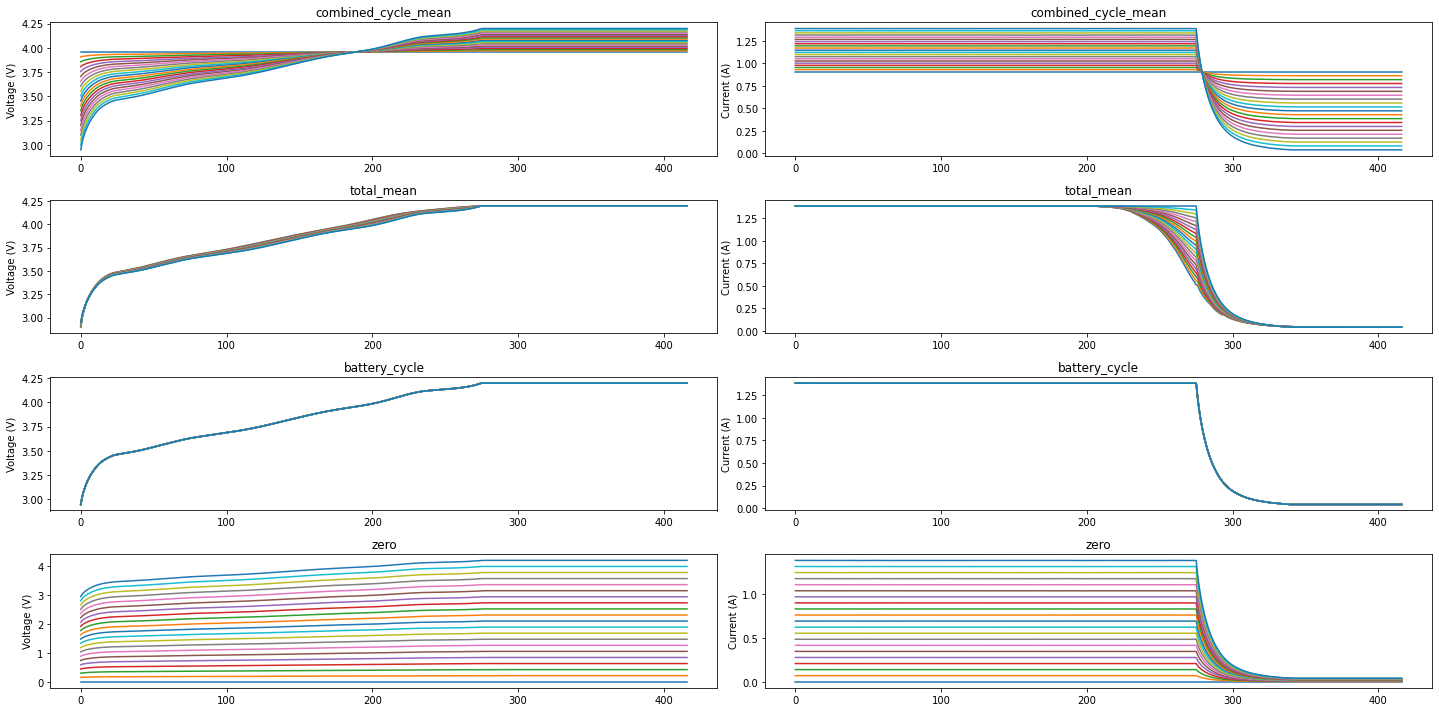

In [12]:
# plot for a data set of cycle 0
pcs.array_subplots(interpolated_charge_cycles0, rows=4, cols=2, figsize=(20, 10))

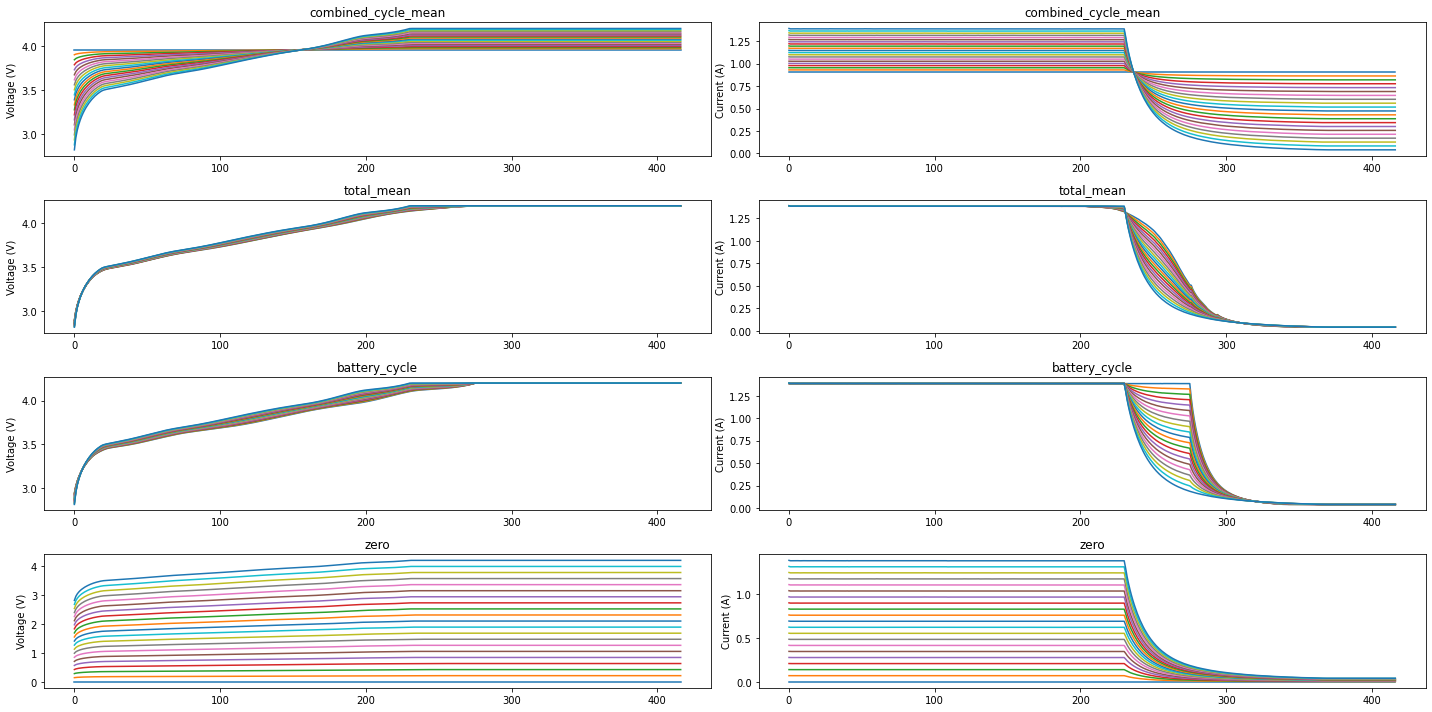

In [13]:
# plot for a data set of cycle 9
pcs.array_subplots(interpolated_charge_cycles9, rows=4, cols=2, figsize=(20, 10))

In the figures above we see the steps between the baseline and the input data. The cycle 0 and cycle 9 data have both been plotted to show the difference in the "battery_cycle" baseline method. If we were to do this with an image the image would slowly come into focus from it's original all black slate. This is very intuitive, however, as can be seen by our plots our intuition doesn't come that easy. These figures demonstrate the importance of the baseline in our case and how the relationship is relative to the baseline and not directly to the input. 

Consequently, this is where we can begin to work our minds around the intuitive reason for the best selection of baseline. First, lets look at the "zero" and "combined_cycle_mean" baselines. In both of these methods there is a large difference in the low voltage and constant max voltage portions, which, intuitively shouldn't provide much information to the model because they are all relatively similar for all datasets. If we look at the current, we se the same large change in the constant portion of the data which intuitively should not be very descriptive. Additionally, this engineered difference in constant values may skew the integrated gradients to favour those sections. As a result, these are likely not the best selection for baseline.

Next, we discuss the "total_mean" and 'battery_cycle" baseline methods. For both methods we see that the low voltage and max voltage sections show little gradient which is what we would expect. Now, lets think about what it means to degrade batteries from these baselines as references. What does it mean to degrade a battery from the mean of all degradation levels? It is hard to understand becuase it means that some charge cycles could have a lower level of degradation than the reference. Now, what does it mean to degrade a battery from it's inital fresh battery state? This makes sense as a reference because it is the difference from this profile that describes how much a battery has degraded.

Finally, in terms of the gradient that we are calculating the battery_cycle method makes sense becuase inputing a fresh battery charge cycle will result in a gradient of 0, in effect, there is 0 probability that the battery has degraded. This is analagous to our all black picture; as the battery degrades the features in the charge cycle get clearer and clearer.

## Computing Gradients

In this section we show how to compute the gradient and go through some more intuition/explanation of what baseline makes sense.

A description of the gradients is given by the second link as, "The gradients of F(), your model function, represents the direction of maximum increase between your predictions with respect to your input." In our case, since we are doing regression, the gradient tells us which points in the charge cycle have the steepest local slope between our output models estimated SOH with respect to the same point in the baseline. A.k.a which data points are most descriptive.

In [14]:
def compute_gradients(charge_cycles):
    """
    Compute gradients between charge_cycles and the models predictions from them.
    Args:
        charge_cycles(tf.tensor): interpolated charge profiles between the baseline and chosen charge cycle.
    Returns:
        gradient(tf.tensor): Calculated gradients.
    """
    with tf.GradientTape() as tape:
        tape.watch(charge_cycles)
        predictions = model(charge_cycles)
    return tape.gradient(predictions, charge_cycles)

In [15]:
# compute path gradients for cycle 0 and cycle 9 data
path_gradients0 = { method: compute_gradients(interpolated_charge_cycle)
                   for method, interpolated_charge_cycle in interpolated_charge_cycles0.items() }
path_gradients9 = { method: compute_gradients(interpolated_charge_cycle)
                   for method, interpolated_charge_cycle in interpolated_charge_cycles9.items() }

We will demonstrate the gradients normalized by their input values to try and discover what is happening inside this process.

In [16]:
def plot_path_gradients(path_gradients, interpolated_charge_cycles, baselines, figsize=(15,20)):
    """
    Plot gradients normalized by their input values as a scattery plot.
    Args:
        path_gradients(dict): computed gradients.
        interpolated_charge_cycles(dict): interpolated charge cycles.
        baselines(dict): chosen baselines.
        figsize(tuple): (width,height) figure dimension tuple
    """
    fig, axs = plt.subplots(nrows=len(methods), ncols=5, squeeze=False, figsize=figsize)

    for k, method in enumerate(methods):
        x = [[ idx ] for idx in range(0,path_gradients[method].shape[1])]
        count = 0
        for i in range(0,20,4):
            # data normalized by input
            scale = tf.math.abs(interpolated_charge_cycles[method] - baselines[method])
            axs[k,count].scatter(x,scale[i,:,0]*tf.math.abs(path_gradients[method][i][:,0]))
            axs[k,count].scatter(x,scale[i,:,1]*tf.math.abs(path_gradients[method][i][:,1]), alpha=0.4)
            axs[k,count].set_title(method)
            # axs[0,count].set_ylim([0, 2])
            count += 1
    plt.tight_layout()

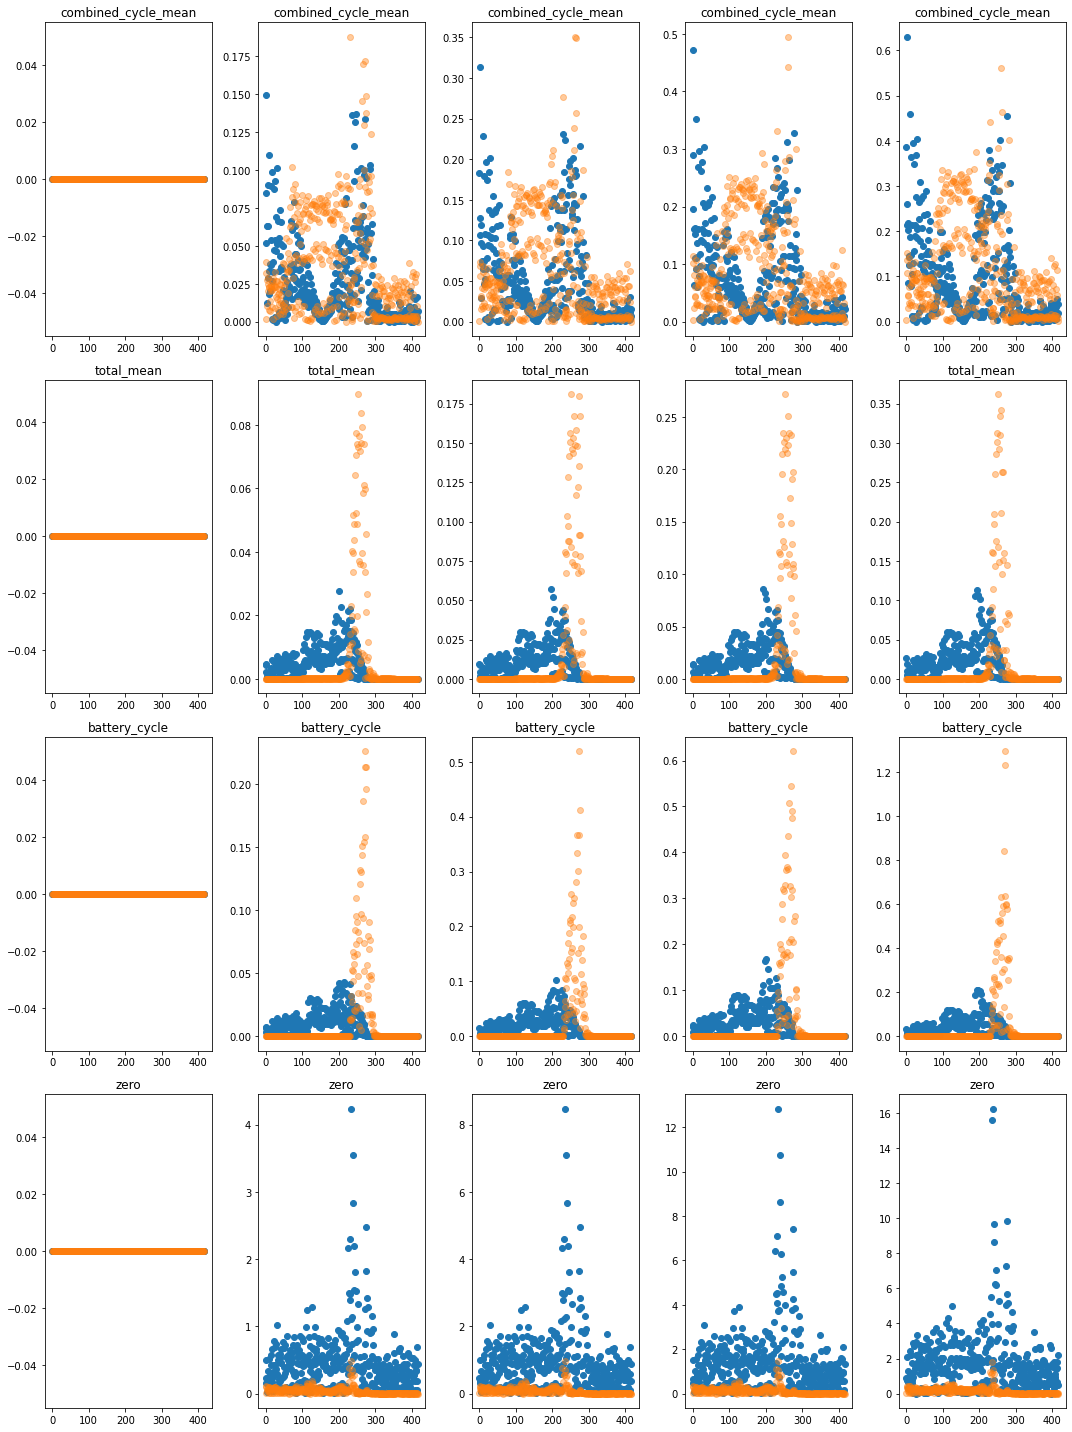

In [17]:
plot_path_gradients(path_gradients9, interpolated_charge_cycles9, baselines)

In the above plots the blue are the voltage gradients and the orange are the current gradients. These plots are harder to evaluate than the interpolation plots, nevertheless, they still provide some insight into the baseline choice. First, the "combined_cycle_mean" plots show that this baseline indeed skews the data towards the ends as we expected. Additionally, the current data has a dependence on the constant current portion which doesn't make sense intuitively. 

Next, the "zero" method performs better, and shows an increasing dependence on the total time to full voltage, however, it shows a weak dependence on the constant voltage current data which we know is important from training the model.

Finally, the "total_mean" and "battery_cycle" methods are quite similar however, we will see a reduction in consistency from the "total_mean" method if we select a charge cycle that is on the other side of the mean. This will be demonstrated below. 

In [18]:
charge_cycle3 = generate_baseline('battery_cycle', cycle_number=3)
interpolated_charge_cycles3 = { method: interpolate_charge_cycles(baseline, charge_cycle3, alphas) for method, baseline in baselines.items() }
path_gradients3 = { method: compute_gradients(interpolated_charge_cycle)
                   for method, interpolated_charge_cycle in interpolated_charge_cycles3.items() }

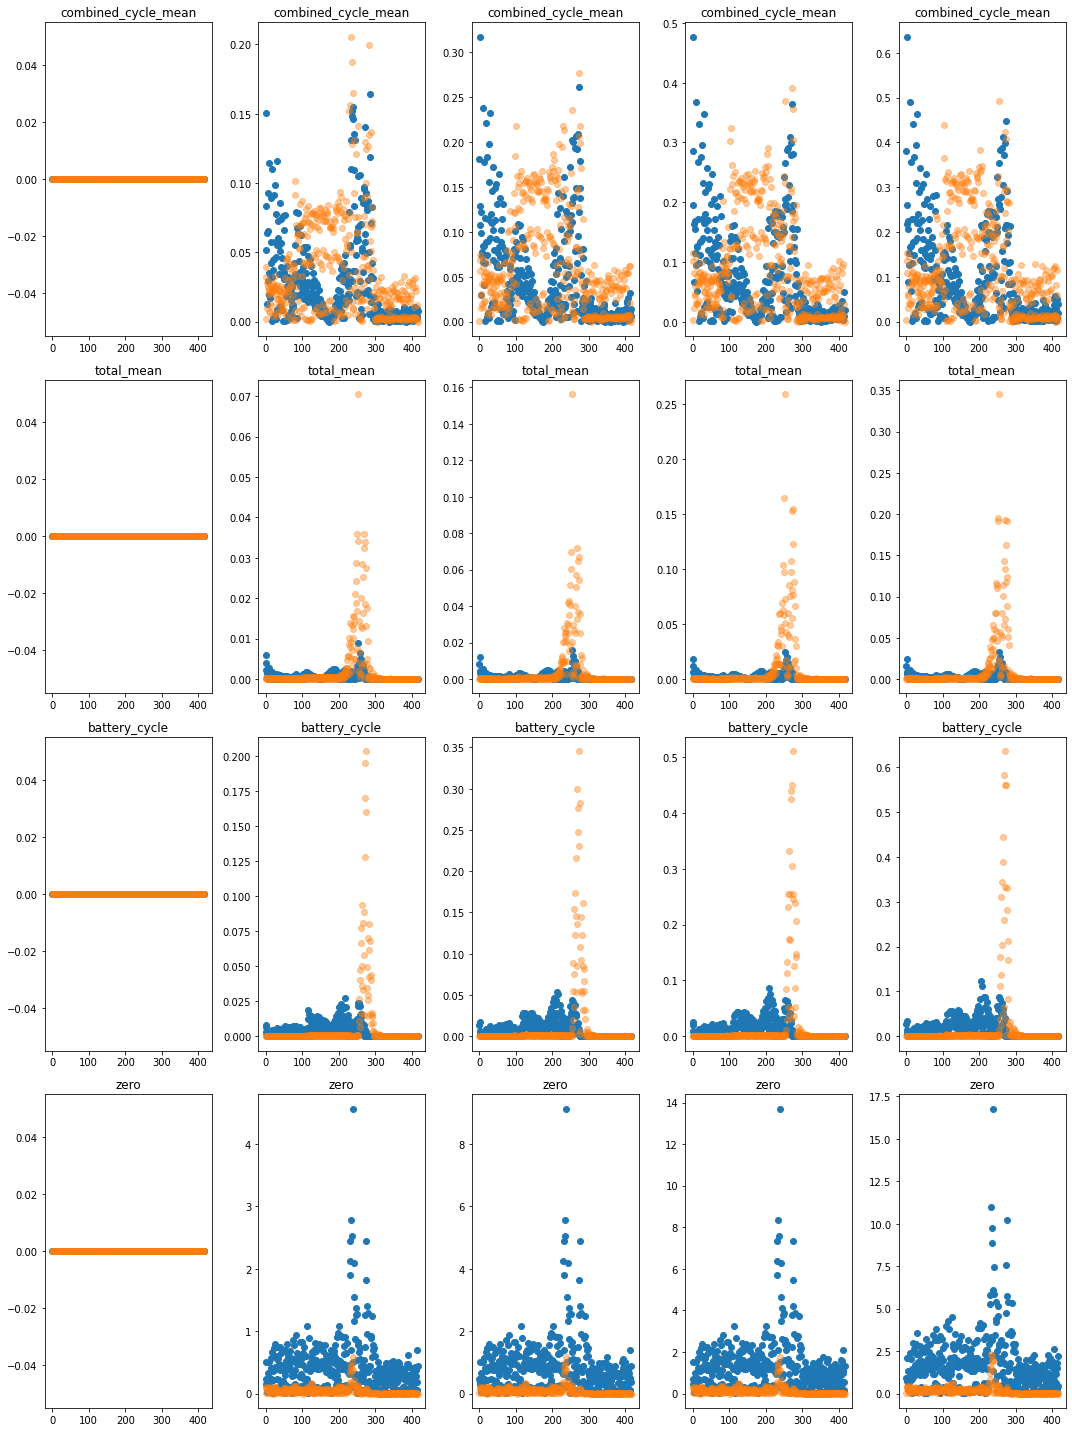

In [19]:
plot_path_gradients(path_gradients3, interpolated_charge_cycles3, baselines)

In [20]:
pred = model(interpolated_charge_cycles3['battery_cycle'])
# pred_accuracy = (pred.numpy()-train_labels[0][0])/max(abs(pred.numpy()-train_labels[0][0]))
pred_accuracy = pred.numpy()-train_labels[3][0]

In [ ]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_accuracy)
ax1.set_title('Prediction accuracy over alpha')
ax1.set_ylabel('model - actual')
ax1.set_xlabel('alpha')
# ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1,2])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average data point gradients (normalized) over alpha')
ax2.set_ylabel('Average data point gradients')
ax2.set_xlabel('alpha');
# ax2.set_ylim([0, 1]);
# ax2.set_xlim([0, 0.4])

## Integral Calculation

Riemann trapezoidal integral approximation is performed in this section. It is common and can be explored more in the second reference.

In [22]:
def integral_approximation(gradients):
    """
    Estimate integral using the Reimann trapezoidal method.
    Args:
        gradients(tf.Tensor): Calculated gradients.
    Returns:
        integrated_gradients(tf.Tensor): The integration of the gradients.
    """
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

## Combining Sections

In this section we combine the interpolation, gradient calculation, and integral approximation together to build a integrated_gradients function.

In [23]:
def integrated_gradients(baseline, charge_cycle, m_steps=50, batch_size=32):
    """
    Calculate the integrated gradients.
    Args:
        baseline(tf.Tensor): Chosen baseline.
        charge_cycle(tf.Tensor): Input charge cycle being evaluated.
        m_steps(int): Number of interpolation and integration steps.
        batch_size(int): batch size for batch computation.
    Returns:
        integrated_gradients(tf.Tensor): Integrated gradients for each data point in charge_cycle.
    """
    # Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    
    # Collect gradients
    gradient_batches = []
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        
        gradient_batch = one_batch(baseline, charge_cycle, alpha_batch)
        gradient_batches.append(gradient_batch)
          
    # Concatenate path gradients together row-wise into single tensor.
    total_gradients = tf.concat(gradient_batches, axis=0)
    
    # Integral approximation through averging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)
    
    # Scale integrated gradients with respect to input.
    integrated_gradients = (charge_cycle - baseline) * avg_gradients
    
    return integrated_gradients

In [24]:
@tf.function
def one_batch(baseline, charge_cycle, alpha_batch):
    """
    Perform interpolation and compute gradients for one batch.
    
    This function is primarily just to improve speed.
    Args:
        baseline(tf.Tensor): chosen baseline.
        charge_cycle(tf.Tensor): Input charge cycle being evaluated.
        alpha_batch(tf.Tensor): Alphas of size batch_size.
    Returns:
        gradient_batch(tf.Tensor): Calculated gradients for each point in each charge cycle in alpha_batch.
    """
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_charge_cycles(baseline, charge_cycle, alpha_batch)
    
    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(interpolated_path_input_batch)
    
    return gradient_batch

Now we visualize the points importance.

## Attributions plotting function

In [25]:
def plot_attributions(idx_list, ig_attributions, rows=1, cols=2, show_gradient=False, linewidth=1.0, figsize=None, show_colorbar=True, save=None):
    """
    Plot the integrated gradients attributions as a heatmap.
    Args:
        idx_list(list): List of charge cycle indexes to be plotted.
        ig_attributions(list): List of integrated gradients attributions
                               to be plotted.
        rows(int): Number of rows in the subplots grid.
        cols(int): Number of columns in the subplots grid.
        show_gradients(bool): plot scaled gradients along bottom of plot
                              iff True.
        linewidth(float): line width in plot.
        figsize(tuple): (width, height) of figure.
        show_colorbar(bool): Plot colorbar iff True.
        save(str): Save image to dir_path as png with filename = save.
    """
    
    if figsize is not None:
        fig, ax = plt.subplots(rows,cols, figsize=figsize)
    else:
        fig, ax = plt.subplots(rows,cols)
        
    for k in idx_list:
        line_data = train_features[k,:,:].astype('float32')
        color_V = (tf.math.abs(ig_attributions[k][:,0])*255/tf.reduce_max(tf.math.abs(ig_attributions[k][:,0]))).numpy()
        color_A = (tf.math.abs(ig_attributions[k][:,1])*255/tf.reduce_max(tf.math.abs(ig_attributions[k][:,1]))).numpy()

        x = np.arange(0, line_data.shape[0])
        V = line_data[:,0]
        A = line_data[:,1]

        if rows == 1:
            N = len(x)
            if show_gradient:
                ax[0].plot(x,tf.math.abs(ig_attributions[k][:,0])+min(V), alpha=0.4)
                ax[1].plot(x,tf.math.abs(ig_attributions[k][:,1])+min(A), alpha=0.4)
                
            for i in range(N-1):
                if math.isnan(color_V[i]):
                    color_V[i] = 0
                if math.isnan(color_A[i]):
                    color_A[i] = 0
                    
                im0 = ax[0].plot(x[i:i+2]*5*7/60, V[i:i+2], color=plt.cm.jet(int(color_V[i])), linewidth=linewidth)
                im1 = ax[1].plot(x[i:i+2], A[i:i+2], color=plt.cm.jet(int(color_A[i])), linewidth=linewidth)
            
            ax[0].grid(b=True)
            ax[1].grid(b=True)
            
            ax[0].set_title('Voltage Attributions for Cell 1')
            ax[1].set_title('Current Attributions for Cell 1')
            ax[0].set_xlabel('Time [min]')
            ax[1].set_xlabel('Time [min]')
            ax[0].set_ylabel('Voltage [V]')
            ax[1].set_ylabel('Current [A]')
            # ax[0].set_xlim([55, 170])
            # ax[0].set_ylim([3.7, 4.25])
            # ax[1].set_xlim([210, 320])
            # ax[1].set_ylim([0, 4.25])
                
        else:
            N = len(x)
            if show_gradient:
                ax[k,0].plot(x,tf.math.abs(ig_attributions[k][:,0])+min(V), alpha=0.4)
                ax[k,1].plot(x,tf.math.abs(ig_attributions[k][:,1])+min(A), alpha=0.4)
                
            for i in range(N-1):
                if math.isnan(color_V[i]):
                    color_V[i] = 0
                if math.isnan(color_A[i]):
                    color_A[i] = 0
                    
                ax[k,0].plot(x[i:i+2], V[i:i+2], color=plt.cm.jet(int(color_V[i])), linewidth=linewidth)
                ax[k,1].plot(x[i:i+2], A[i:i+2], color=plt.cm.jet(int(color_A[i])), linewidth=linewidth)
            
            ax[k,0].grid(b=True)
            ax[k,1].grid(b=True)
            
            ax[k,0].set_title('Voltage Attributions for Cell 1')
            ax[k,1].set_title('Current Attributions for Cell 1')
             
    
    if show_colorbar:
        plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=ax[0])
        plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=ax[1])
        
    if save is not None:
        fig.savefig(dir_path+save+'.png', dpi=400, bbox_inches='tight')

# Evaluate Baselines Using HeatMap

In this section we evaluate the baseline methods over an entire battery life cycle to see if there is any trends in the discriptive data identified by the IG method.

In [26]:
methods

['combined_cycle_mean', 'total_mean', 'battery_cycle', 'zero']

### combined_cycle_mean

In [35]:
ig_attributions = []
for i in range(0,12):
    charge_cycle = tf.convert_to_tensor(train_features[i,:,:].astype('float32'), dtype='float32')
    ig_attributions.append(integrated_gradients(baselines['combined_cycle_mean'], charge_cycle, m_steps=50))

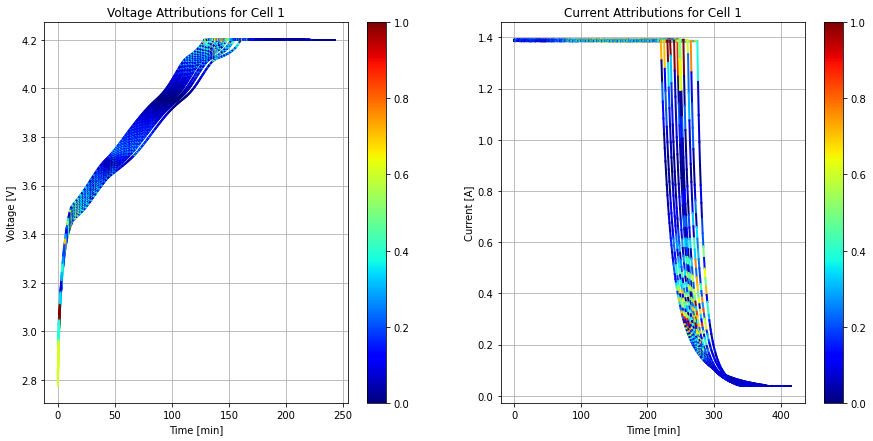

In [36]:
# baseline is combined_cycle_mean
%matplotlib inline
idx_list = np.arange(0,12)
plot_attributions(idx_list, ig_attributions, rows=1, cols=2, linewidth=2.0, show_gradient=False, figsize=(15,7), show_colorbar=1)

### total_mean

In [37]:
ig_attributions = []
for i in range(0,12):
    charge_cycle = tf.convert_to_tensor(train_features[i,:,:].astype('float32'), dtype='float32')
    ig_attributions.append(integrated_gradients(baselines['total_mean'], charge_cycle, m_steps=50))

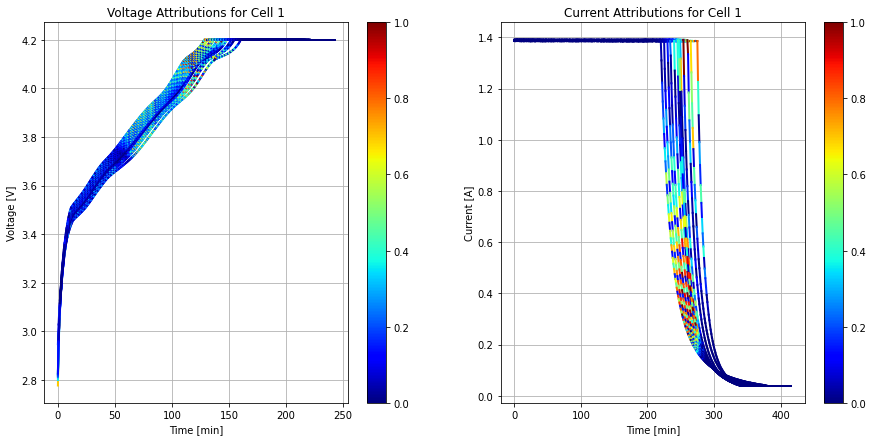

In [38]:
# baseline is total_mean
%matplotlib inline
idx_list = np.arange(0,12)
plot_attributions(idx_list, ig_attributions, rows=1, cols=2, linewidth=2.0, show_gradient=False, figsize=(15,7), show_colorbar=1)

### battery_cycle

In [39]:
ig_attributions = []
for i in range(0,12):
    charge_cycle = tf.convert_to_tensor(train_features[i,:,:].astype('float32'), dtype='float32')
    ig_attributions.append(integrated_gradients(baselines['battery_cycle'], charge_cycle, m_steps=50))

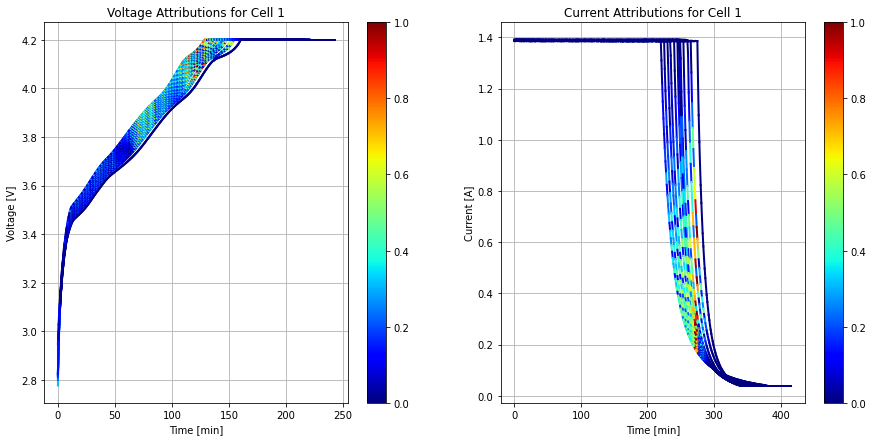

In [40]:
# baseline is battery_cycle
%matplotlib inline
idx_list = np.arange(0,12)
plot_attributions(idx_list, ig_attributions, rows=1, cols=2, linewidth=2.0, show_gradient=0, figsize=(15,7), show_colorbar=1)

### zero

In [41]:
ig_attributions = []
for i in range(0,12):
    charge_cycle = tf.convert_to_tensor(train_features[i,:,:].astype('float32'), dtype='float32')
    ig_attributions.append(integrated_gradients(baselines['zero'], charge_cycle, m_steps=50))

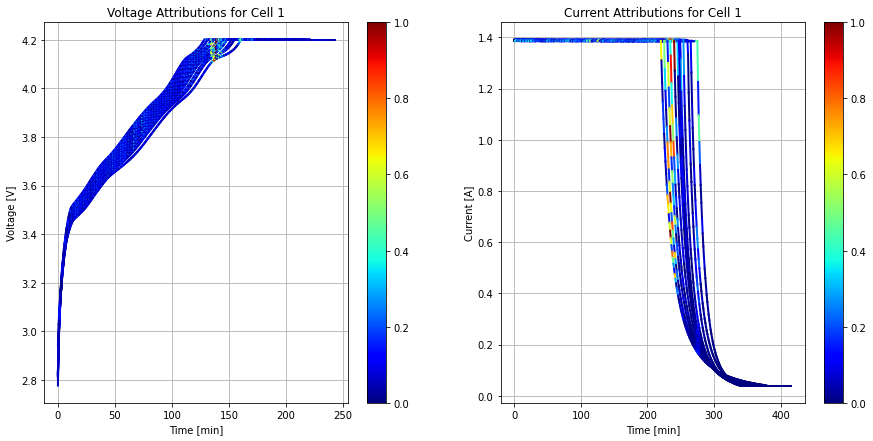

In [42]:
# baseline is zero
idx_list = np.arange(0,12)
plot_attributions(idx_list, ig_attributions, rows=1, cols=2, linewidth=2.0, show_gradient=0, figsize=(15,7), show_colorbar=1)

So, what can these figures tell us about the baselines that we used, and can they be used to identify the best one? First of all, we see that the result from the "zero" method is quite unintelligable so we will just discard.

Next we see that the "total_mean" method seems to be split into two regions, especially for the current data. This is likely because a portion of the data will lie above the mean and a portion will lie below. This segmentation of features signifies that this is not a useful method to use. 

For the "combinde_cycle_mean" method we see the expected correlation with the low voltage and high voltage data; however, it has a concerning correlation with the constant current data that we know isn't discriptive.

Finally, we come to the "battery_cycle" method which exhibits a nice verticle color correlation. The verticle correlation is promising because it suggests a time dependency in the model which is what we'd expect from using timeseries data. Additionally, there is a correlation with the time to reach maximum voltage and no correlation with the constant voltage and constant current data.

From this analysis it is clear that the "battery_cycle" baseline is the best baseline to use to highlight the important features in the data. The only remaining question is if we can use this information for anything useful.

Ah yes... finally, the final step in this notebook. Now we answer the question, "what use is the information that the battery_cycle figures provide?

Looking at the voltage plot first, we see there is a dependence on the middle and high voltage regions. Additionally, the area where maximum voltage is reached is also very important. Looking at the current plot next, we see an obvious dependence on the variable current portion of the data and not much importance anywhere else.

How can this information help us reduce the amount of data that's needed for the model? Or even help us improve the model? Well, we can make some assumptions about the typical charging of the batteries in a practical situation. It's likely that the low voltage region will very rarely be reached. We can also assume that the region from 3.8 to 4.2 V will be the most actively encountered. Finally, we can assume that the constant voltage phase will be less frequent especially for large battery packs. 

In [35]:
def calc_all_attributions(features):
    ig_attributions = []
    for i in range(0,len(features)):
        charge_cycle = tf.convert_to_tensor(features[i,:,:].astype('float32'), dtype='float32')
        ig_attributions.append(integrated_gradients(baselines['battery_cycle'], charge_cycle, m_steps=50))
        
    return np.array(ig_attributions)

In [ ]:
train_attributions = calc_all_attributions(train_features_notemp)
val_attributions = calc_all_attributions(val_features)
MG_attributions = calc_all_attributions(MG_features)

In [ ]:
np.save('path/to/directory/train_attributions.npy', train_attributions)
np.save('path/to/directory/val_attributions.npy', val_attributions)
np.save('path/to/directory/MG_attributions.npy', MG_attributions)